---
title: "Python Class for cross-validation of NNM-FW"
author: "Saikat Banerjee"
format:
  html:
      theme: default
      code-fold: show
  ipynb: default
date: "2023-07-19"
file-modified: "2023-07-19"
abstract: "Write a CV class for NNM with Frank-Wolfe algorithm"

---

# About

I mask random elements of the input matrix and perform matrix completion using NNMFW. The minimum error for the masked elements in the recovered matrix is used for cross-validation.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

from nnwmf.optimize import NNMFW_CV
from nnwmf.optimize import NNMFW

# Simulate

In [2]:
ntrait = 4 # categories / class
ngwas  = 50 # N
nsnp   = 100 # P
nfctr  = 40 # K

In [3]:
Y, Y_true, L, F, mean, noise_var, sample_indices = mpy_simulate.simulate(ngwas, nsnp, ntrait, nfctr, std = 0.5, do_shift_mean = False)
Y_cent = mpy_simulate.do_standardize(Y, scale = False)
Y_std  = mpy_simulate.do_standardize(Y)

# NNMFW

In [4]:
nnm = NNMFW(show_progress = True, svd_max_iter = 50, debug = True)
nnm.fit(Y_cent, 40.0)

2023-07-24 14:38:18,800 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.532. Duality Gap 851.878
2023-07-24 14:38:19,111 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 100. Step size 0.007. Duality Gap 10.6105


In [5]:
nnm._convergence_msg

'Step size converged below tolerance.'

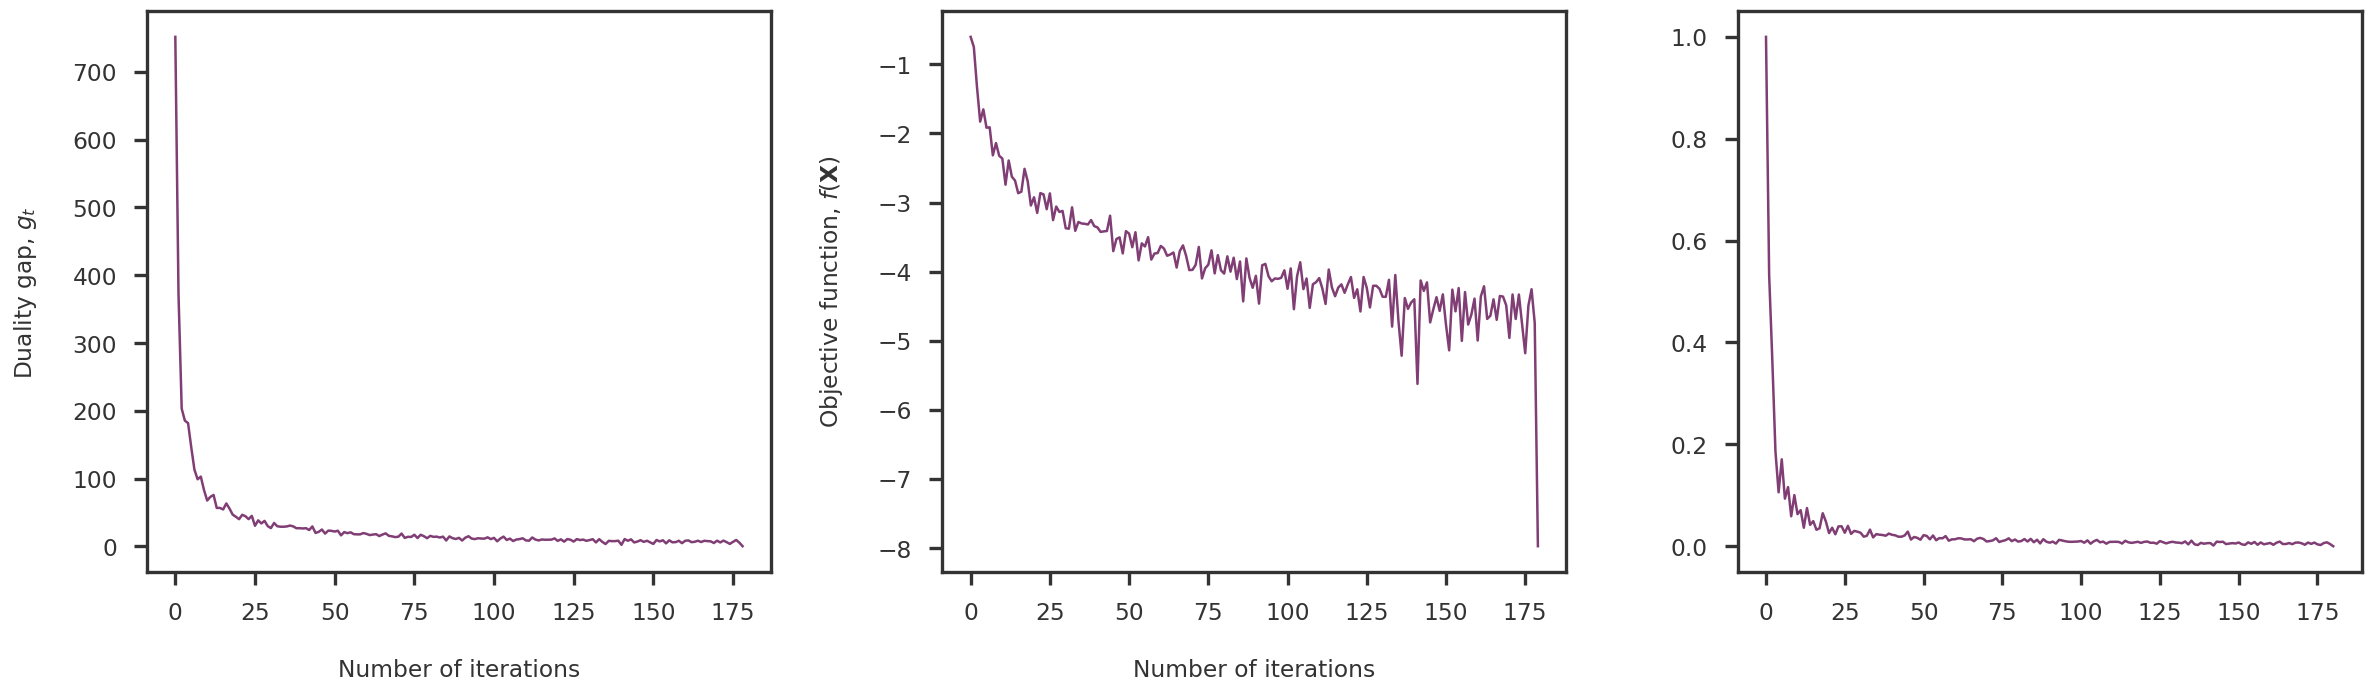

In [43]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

kp = len(nnm._st_list)
fx_arr = np.array(nnm._fx_list)
fx_rel_diff_log10 = np.log10(np.abs(np.diff(fx_arr) / fx_arr[1:]))

ax1.plot(np.arange(kp - 2), nnm._dg_list[2:kp])
# ax2.plot(np.arange(kp - 1), np.log10(fx_list[1:kp]))
ax2.plot(np.arange(kp - 1), fx_rel_diff_log10)
ax3.plot(np.arange(kp), nnm._st_list)

ax1.set_xlabel("Number of iterations")
ax2.set_xlabel("Number of iterations")
ax1.set_ylabel(r"Duality gap, $g_t$")
ax2.set_ylabel(r"Objective function, $f(\mathbf{X})$")
fig.tight_layout(w_pad = 2.0)
plt.show()

# Functions for cross-validation

In [45]:
def psnr(original, recovered):
    n, p = original.shape
    maxsig2 = np.square(np.max(original) - np.min(original))
    mse = np.sum(np.square(recovered - original)) / (n * p)
    res = 10 * np.log10(maxsig2 / mse)
    return res

def masked_rmse(original, recovered, mask):
    n = np.sum(mask)
    mse = np.sum(np.square((original - recovered) * mask)) / n
    return np.sqrt(mse)

def generate_rseq(Y):
    r_min = 1
    r_max = np.linalg.norm(Y, 'nuc')
    nseq  = int(np.floor(np.log2(r_max)) + 1) + 1
    r_seq = np.logspace(0, nseq - 1, num = nseq, base = 2.0)
    return r_seq

def generate_mask(Y, folds = 1, test_size = 0.33):
    n, p = Y.shape
    O = np.ones(n * p)
    ntest = int(test_size * n * p)
    O[:ntest] = 0
    np.random.shuffle(O)
    return O.reshape(n, p) == 0

def generate_fold_labels(Y, folds = 2, test_size = None, shuffle = True):
    n, p = Y.shape
    fold_labels = np.ones(n * p)
    ntest = int ((n * p) / folds) if test_size is None else int(test_size * n * p)
    for k in range(1, folds):
        start = k * ntest
        end = (k + 1) * ntest
        fold_labels[start: end] = k + 1
    if shuffle:
        np.random.shuffle(fold_labels)
    return fold_labels.reshape(n, p)

def generate_masked_input(Y, mask):
    Ymiss_nan = Y.copy()
    Ymiss_nan[mask] = np.nan
    Ymiss_nan_cent = Ymiss_nan - np.nanmean(Ymiss_nan, axis = 0, keepdims = True)
    Ymiss_nan_cent[mask] = 0.0
    return Ymiss_nan_cent

def nnmfw_cv(Y, folds = 2, r_seq = None):
    if r_seq is None:
        r_seq = generate_rseq(Y)
    rmse_dict = {r: list() for r in r_seq}
    fold_labels = generate_fold_labels(Y, folds = folds)
    for fold in range(folds):
        mask = fold_labels == fold + 1
        Ymiss = generate_masked_input(Y, mask)
        for r in r_seq:
            nnm_cv = NNMFW(suppress_warnings = True)
            nnm_cv.fit(Ymiss, r, mask = mask)
            rmse = masked_rmse(Y, nnm_cv._X, mask)
            rmse_dict[r].append(rmse)
    return rmse_dict

In [46]:
rmse_dict = nnmfw_cv(Y_cent, folds = 5)

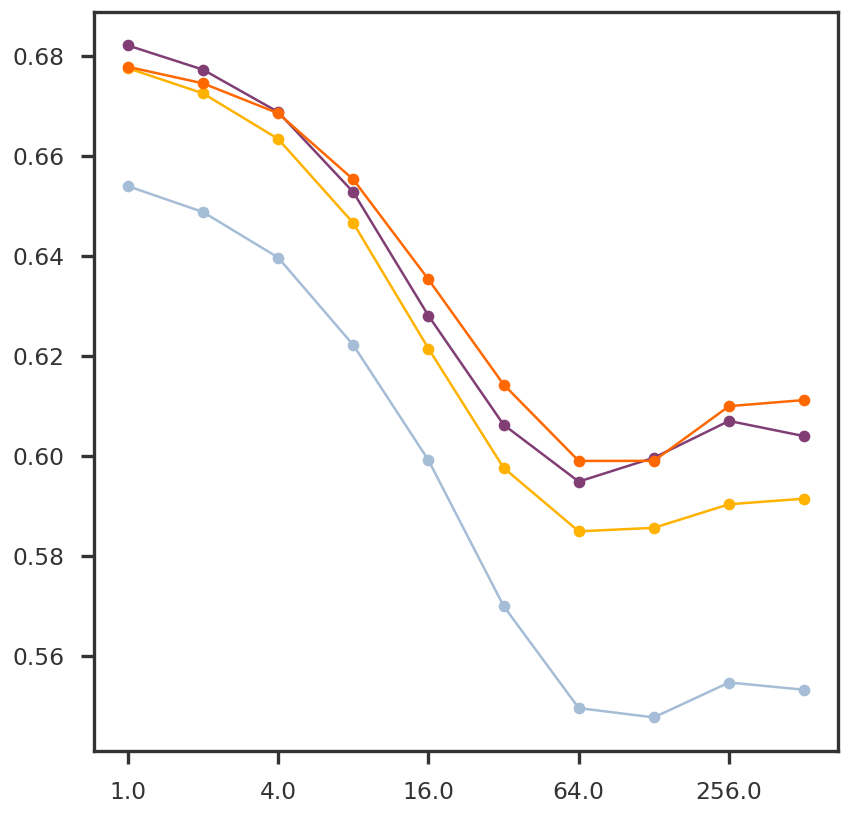

In [47]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for k in range(4):
    ax1.plot(np.log10(list(rmse_dict.keys())), [x[k] for x in rmse_dict.values()], 'o-')
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
plt.show()

In [48]:
mean_err = {k: np.mean(v) for k,v in rmse_dict.items()}

In [49]:
min(mean_err, key=mean_err.get)

64.0

# Class for cross-validation

In [50]:
nnmcv = NNMFW_CV(chain_init = False, reverse_path = False)
nnmcv.fit(Y_cent)

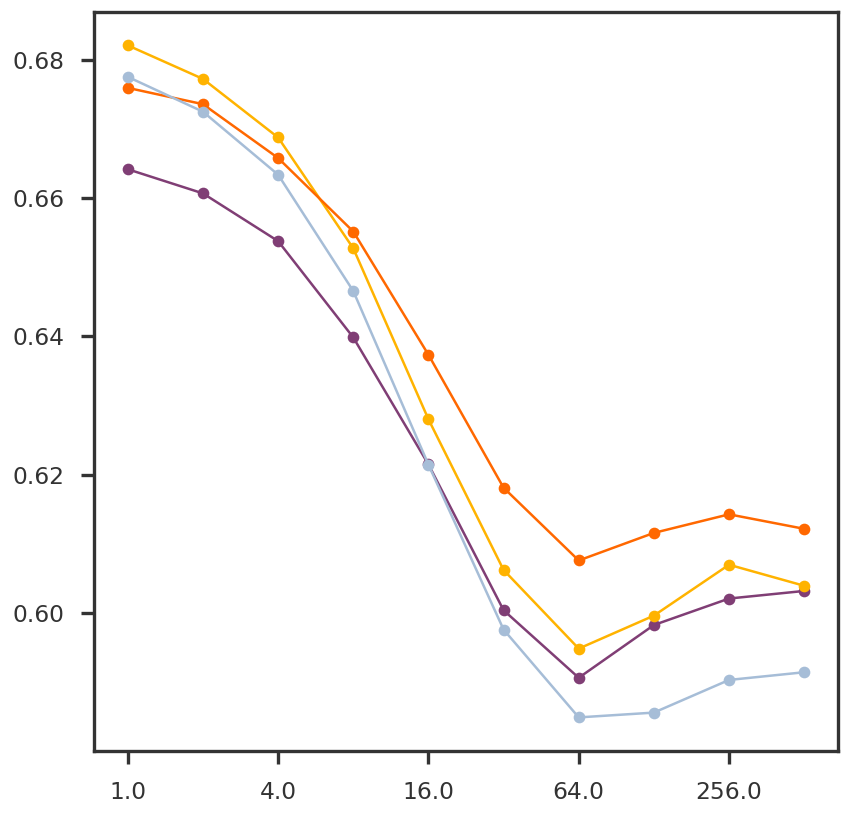

In [59]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for k in range(2):
    #ax1.plot(np.log10(list(nnmcv.training_error.keys())), [x[k] for x in nnmcv.training_error.values()], 'o-')
    ax1.plot(np.log10(list(nnmcv.test_error.keys())), [x[k] for x in nnmcv.test_error.values()], 'o-')
    ax1.plot(np.log10(list(rmse_dict.keys())), [x[k] for x in rmse_dict.values()], 'o-')
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
plt.show()